# Analyse de sensibilités sur les prédictions - visualisation - Partie 2

## 1. Import du modèle et des données

In [1]:
import pickle

with open('data_model_rf.pickle', 'rb') as handle:
    data_model_dict = pickle.load(handle)

X_train, X_test, y_train, y_test, model = data_model_dict.values()
f_predict = lambda x: model.predict_proba(x)[:,1]

/Users/jms/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jms/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jms/prod/20181003_Technical_training_interpretability/.venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
## Exemple : Une prédiction pour 10 échantillons aléatoires du jeu de test:
f_predict(
    X_test.sample(10, random_state=42)
)

array([0.33058554, 0.54339778, 0.25560691, 0.54657462, 0.0544803 ,
       0.77699009, 0.78250217, 0.31317756, 0.59730188, 0.76966065])

## 2. Permutation importances

In [3]:
%%time
from eli5.sklearn.permutation_importance import PermutationImportance

PermImp = PermutationImportance(model,
                                n_iter=20,
                                random_state=42,
                                cv='prefit',
                                refit=False)


PermImp.fit(X_test, y_test)
## Plus d'informations ici : https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html

CPU times: user 15.5 s, sys: 201 ms, total: 15.7 s
Wall time: 16 s


In [4]:
%matplotlib inline 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_features_importance(data, importances, n_feat):
    """Plot the features importance barplot.

    Parameters
    ----------
    data: DataFrame,
        data containing colnames used in the model.

    importances: numpy array,
        list of feature importances

    n_feat: int,
        number of features to plot
    """
    indices = np.argsort(importances)[::-1]
    features = data.columns

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices][:n_feat],
                y=features[indices][:n_feat], palette='Blues_r')
    plt.title("Top {} Features Importance".format(n_feat))
    return plt.show()

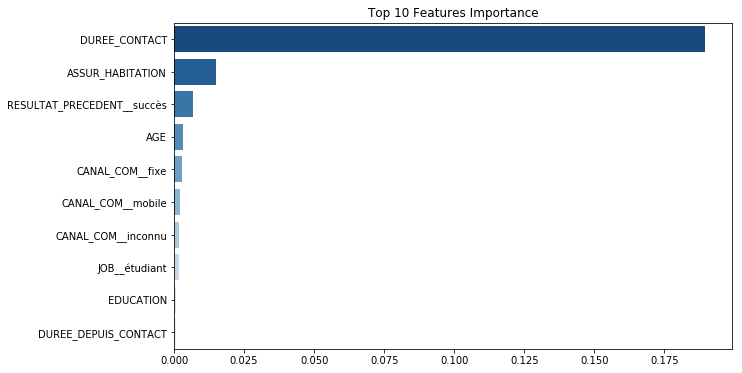

In [5]:
# Les 10 variables les plus importantes du modèle (au sens de la Permutation Importance).

plot_features_importance(data=X_test,
                         importances=PermImp.feature_importances_,
                         n_feat=10)

### 2. Partial Dependance Plots (PDP curves)

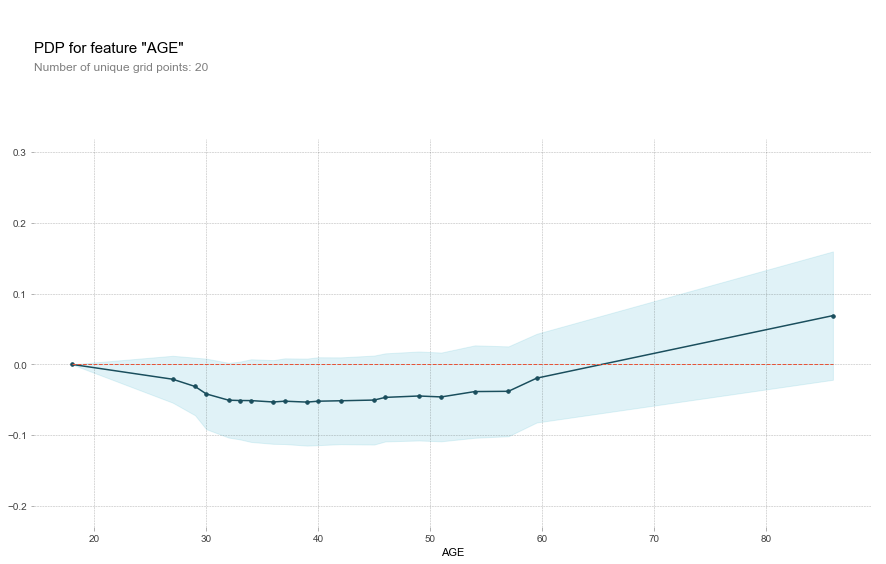

In [6]:
from pdpbox import pdp

# Modifiez le nom de la variable ci-dessous afin d'analyser les variables les plus importantes

variable = 'AGE' 

pdp_goals = pdp.pdp_isolate(model=model,
                            dataset=X_test,
                            model_features=X_test.columns,
                            feature=variable,
                            num_grid_points=20,
                            grid_type='percentile', #possible values: 'equal' or 'percentile'
)

# plot it
pdp.pdp_plot(pdp_goals, variable)
plt.show()


# As a reminder, the top 3 important variables are:
# DUREE_CONTACT, SOLDE, AGE


## 3. Individual Conditional Expectation Curves (ICE curves)

Text(0.5,1,'ICE Curves')

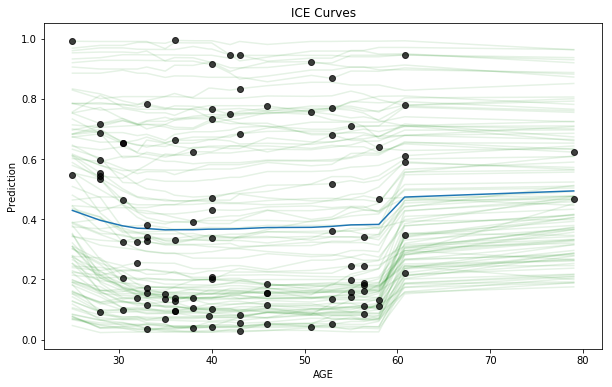

In [7]:
from pycebox.ice import ice, ice_plot
from matplotlib import pyplot as plt
from matplotlib.cm import PuOr

# WARNING: cette librairie n'est pas très bien documentée.
# http://austinrochford.github.io/PyCEbox/docs/


# On prend un sous-échantillon de 100 personnes. Au-delà, la visualisation ne donnera rien.
X_ref = X_test.copy().sample(100, random_state=42)


# Modifiez le nom de la variable ci-dessous afin d'analyser les variables les plus importantes
variable = 'AGE' 


# As a reminder, the top 3 important variables are:
# DUREE_CONTACT, SOLDE, AGE


ice_df = ice(X_ref, variable, f_predict, num_grid_points=20)

fig, ax_ice = plt.subplots(nrows=1, ncols=1,figsize=(10, 6))

ice_plot(ice_df,
         plot_points=True,
         point_kwargs={'color': 'k', 'alpha': 0.75},
         c='g',
         alpha=0.1,
         plot_pdp=True,
         ax=ax_ice)

ax_ice.set_xlabel(variable)
ax_ice.set_ylabel('Prediction') 
ax_ice.set_title('ICE Curves')